# Resume run and load data

In [7]:
%load_ext autoreload
%autoreload 2

import atexit
import gc
import math
import os
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import wandb

from src import train_utils
from src import viz
from src.dataloader import train_dataloader, val_dataloader
from src.models import PJPE, weight_init, Critic
from src.trainer import _validation_step
from src.callbacks import CallbackList, ModelCheckpoint, Logging, WeightScheduler, Analyze, MaxNorm
from src.train import training_specific_args
from collections import defaultdict
from src.processing import post_process
import src.viz.mpl_plots as plot
from src.viz.mpl_plots import plot_all_proj
import matplotlib.pyplot as plt

import sys; sys.argv=['']; del sys

# Experiment Configuration, Config, is distributed to all the other modules
parser = training_specific_args()
config = parser.parse_args()
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# GPU setup
use_cuda = config.cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
config.device = device  # Adding device to config, not already in argparse
config.num_workers = 4 if use_cuda else 4  # for dataloader

# ignore when debugging on cpu
if not use_cuda:
    # os.environ['WANDB_MODE'] = 'dryrun'  # Doesnt auto sync to project
    os.environ['WANDB_TAGS'] = 'CPU'
    wandb.init(anonymous='allow', project="hpe3d", config=config)  # to_delete
else:
    os.environ['WANDB_MODE'] = 'dryrun'
    wandb.init(anonymous='allow', project="hpe3d", config=config)

config.logger = wandb
config.logger.run.save()
config.run_name = config.logger.run.name  # handle name change in wandb
# Data loading
config.train_subjects = [9, 11]
train_loader = train_dataloader(config)
config.val_subjects = [9, 11]
val_loader = val_dataloader(config)

variant = [['2d', '3d']]

models = train_utils.get_models(variant, config)  # model instances
if config.self_supervised:
    critic = Critic()
    models['Critic'] = critic
optimizers = train_utils.get_optims(variant, models, config)  # optimer for each pair
schedulers = train_utils.get_schedulers(optimizers)

# For multiple GPUs
if torch.cuda.device_count() > 1:
    print(f'[INFO]: Using {torch.cuda.device_count()} GPUs')
    for key in models.keys():
        models[key] = torch.nn.DataParallel(models[key])

# To CPU or GPU or TODO TPU
for key in models.keys():
    models[key] = models[key].to(device)
    # models[key].apply(weight_init)

config.mpjpe_min=float('inf')
config.mpjpe_at_min_val=float('inf')
#*******************************************************************#
config.resume_run = "lively-mountain-2599"

# initiate all required callbacks, keep the order in mind!!!
cb = CallbackList([ModelCheckpoint(),
                    Logging(),                       
                    WeightScheduler(config, strategy="beta_cycling"),
                    # Analyze(500),
                    ])

cb.setup(config = config, models = models, optimizers = optimizers,
            train_loader = train_loader, val_loader = val_loader, variant = variant)

n_pair=1
pair=variant[0]
vae_type="_2_".join(pair)
# model -- encoder, decoder / critic
model=[models[f"Encoder{pair[0].upper()}"],
            models[f"Decoder{pair[1].upper()}"]]
optimizer = [optimizers[n_pair]]
scheduler = [schedulers[n_pair]]

if config.self_supervised:
    model.append(models['Critic'])
    optimizer.append(optimizers[-1])
    scheduler.append(schedulers[-1])


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
[INFO]: Training data loader called
[INFO]: processing subjects: [9, 11]
samples - 8695
[INFO]: Validation data loader called
[INFO]: processing subjects: [9, 11]
samples - 8695


FileNotFoundError: [Errno 2] No such file or directory: '/lhome/sbudara/lab/HPE3D/src/checkpoints/lively-mountain-2599_Encoder2D.pt'

# Run validation epoch and get metrics

In [36]:
# Validation epoch code

cb.on_validation_start()

t_data = defaultdict(list)
loss_dic = defaultdict(int)
normalize_pose = True
epoch = 1
with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        for key in batch.keys():
            batch[key] = batch[key].to(config.device)

        output = _validation_step(batch, batch_idx, model, epoch, config)

        loss_dic['loss'] += output['loss'].item()
        loss_dic['recon_loss'] += output['log']['recon_loss'].item()
        loss_dic['kld_loss'] += output['log']['kld_loss'].item()

        if config.self_supervised:
            loss_dic['gen_loss'] += output['log']['gen_loss'].item()
            loss_dic['critic_loss'] += output['log']['critic_loss'].item()
            loss_dic['D_x'] += output['log']['D_x']
            loss_dic['D_G_z1'] += output['log']['D_G_z1']
            loss_dic['D_G_z2'] += output['log']['D_G_z2']

        for key in output['data'].keys():
            t_data[key].append(output['data'][key])

        del output
        gc.collect()

avg_loss = loss_dic['loss']/len(val_loader)  # return for scheduler

for key in t_data.keys():
    t_data[key] = torch.cat(t_data[key], 0)

# performance
t_data['recon_3d_org'] = t_data['recon_3d'].detach()
if '3D' in model[1].name:
    if normalize_pose and not config.self_supervised:
        t_data['recon_3d'], t_data['target_3d'] = post_process(
            t_data['recon_3d'], t_data['target_3d'])

    elif config.self_supervised:
        t_data['recon_3d'], t_data['target_3d'] = post_process(
            t_data['recon_3d'].to('cpu'), t_data['target_3d'].to('cpu'),
            scale=t_data['scale_3d'].to('cpu'),
            self_supervised=True, procrustes_enabled=False)

    # Speed up procrustes alignment with CPU!
    t_data['recon_3d']=t_data['recon_3d'].to('cuda')
    t_data['target_3d']=t_data['target_3d'].to('cuda')

    pjpe_ = PJPE(t_data['recon_3d'], t_data['target_3d'])
    avg_pjpe = torch.mean((pjpe_), dim=0)
    avg_mpjpe = torch.mean(avg_pjpe).item()
    pjpe = torch.mean(pjpe_, dim=1)

    config.logger.log({"pjpe": pjpe.cpu()})

    # average epochs output
    avg_output = {}
    avg_output['log'] = {}

    avg_output['loss'] = loss_dic['loss']/len(val_loader)
    avg_output['log']['recon_loss'] = loss_dic['recon_loss']/len(val_loader)
    avg_output['log']['kld_loss'] = loss_dic['kld_loss']/len(val_loader)

    # print to console
    print(f"{vae_type} Validation:",
            f"\t\tLoss: {round(avg_output['loss'],4)}",
            f"\tReCon: {round(avg_output['log']['recon_loss'], 4)}",
            f"\tKLD: {round(avg_output['log']['kld_loss'], 4)}", end='')

Start validation epoch


wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2d_2_3d Validation: 		Loss: 7.2813 	ReCon: 0.0035 	KLD: 0.76

# Check outputs

[680.7951]


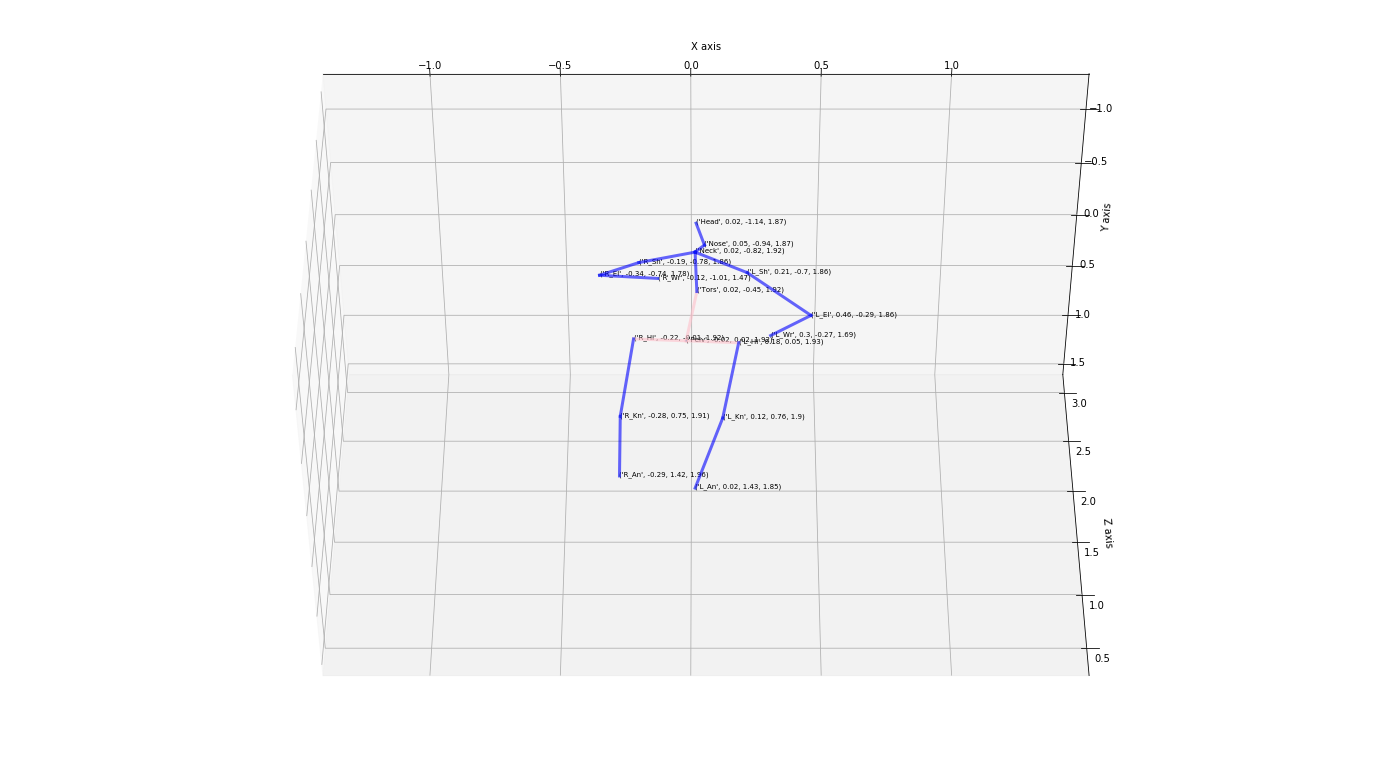

In [38]:
%matplotlib inline

_3d = t_data["recon_3d"][6344].cpu().numpy()
_3d_org = t_data["recon_3d_org"][6344].cpu().numpy()
_3d_target = t_data["target_3d"][6344].cpu().numpy()
_2d = t_data['recon_2d'][6344].cpu().numpy()
_scale = t_data['scale_3d'][6344].cpu().numpy()
_3d = _3d/_scale
_3d_target = _3d_target/_scale

print(_scale)

# plot.plot_3d(_3d_target, color='orange', mode="axis",
#                 show_ticks=True, labels=True, mean_root=True)

plot.plot_3d(_3d_org, color='blue', mode="show",
                show_ticks=True, labels=True, mean_root=True)

# plot.plot_2d(_2d)


In [39]:
print(pjpe.shape)
idx_max = torch.argmax(pjpe)
print(idx_max)
pjpe[idx_max]

torch.Size([6387])
tensor(4960, device='cuda:0')


tensor(1547.7062, device='cuda:0')

In [32]:
len(t_data["recon_3d"])

6387

# Check h5py files

In [1]:
import h5py
annotations_h5 = h5py.File(f'../src/data/h36m17_911.h5', 'r')

for key in annotations_h5.keys():
    print(key)

action
bbox
cam_R
cam_T
cam_c
cam_f
cam_k
cam_p
camera
idx
pose2d
pose3d
pose3d_global
subaction
subject


In [2]:
annotations_h5["action"]

<HDF5 dataset "action": shape (8695,), type "<i8">

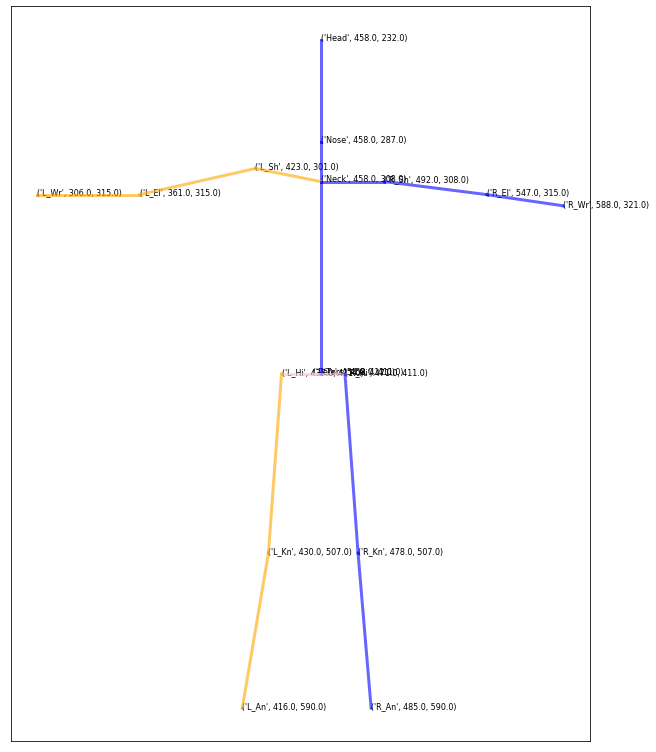

In [40]:
import numpy as np
import src.viz.mpl_plots as plot

pose = np.array([[485., 590.],
       [478., 507.],
       [471., 411.],
       [437., 411.],
       [430., 507.],
       [416., 590.],
       [458., 411.],
       [458., 308.],
       [458., 287.],
       [458., 232.],
       [588., 321.],
       [547., 315.],
       [492., 308.],
       [423., 301.],
       [361., 315.],
       [306., 315.]])


plot.plot_2d(pose, mean_root=True, labels=True)

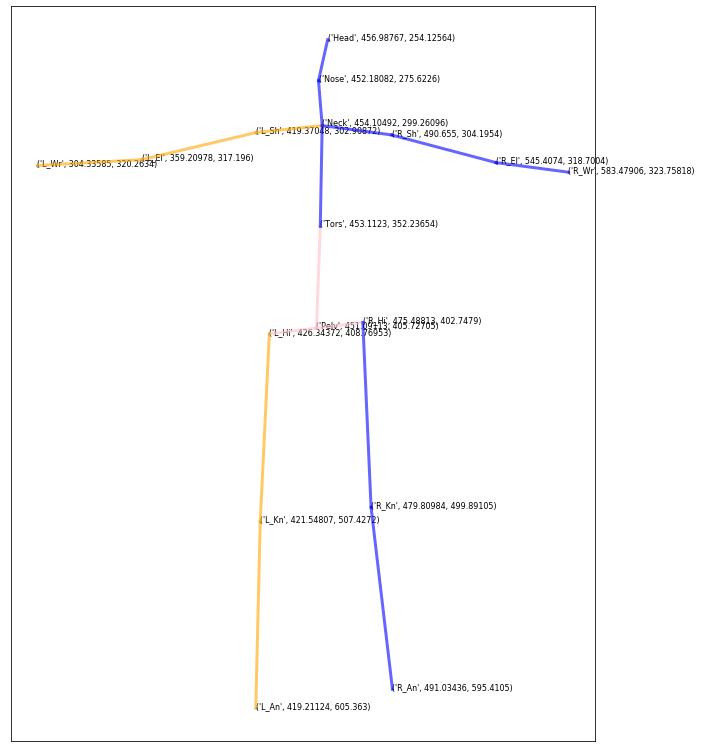

In [16]:
import numpy as np
import src.viz.mpl_plots as plot

pose = np.array([[451.09113, 405.72705],
       [475.48813, 402.7479 ],
       [479.80984, 499.89105],
       [491.03436, 595.4105 ],
       [426.34372, 408.76953],
       [421.54807, 507.4272 ],
       [419.21124, 605.363  ],
       [453.1123 , 352.23654],
       [454.10492, 299.26096],
       [452.18082, 275.6226 ],
       [456.98767, 254.12564],
       [419.37048, 302.90872],
       [359.20978, 317.196  ],
       [304.33585, 320.2634 ],
       [490.655  , 304.1954 ],
       [545.4074 , 318.7004 ],
       [583.47906, 323.75818]])

plot.plot_2d(pose, mean_root=True)



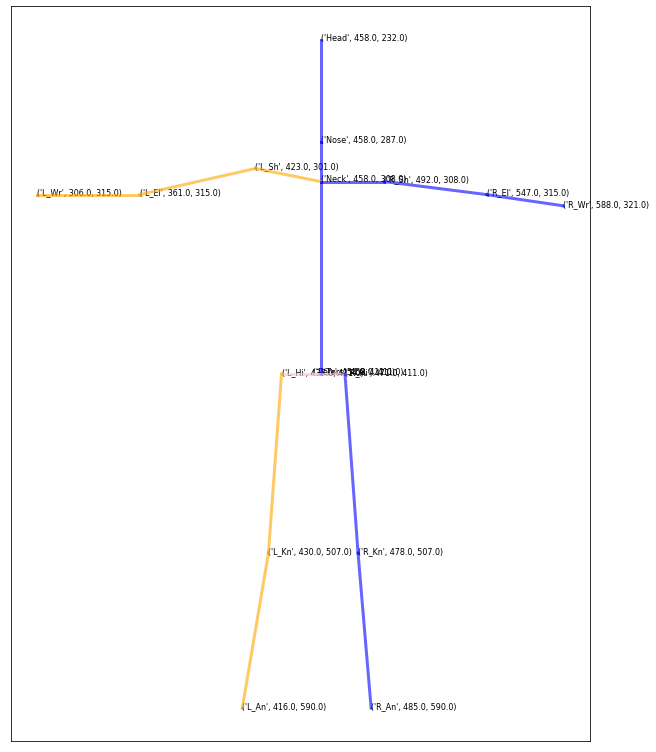

In [54]:
swap_ind = np.array([2,1,0,3,4,5,6,7,8,9,13,14,15,12,11,10])

a = np.array([[[485., 590.],
       [478., 507.],
       [471., 411.],
       [437., 411.],
       [430., 507.],
       [416., 590.],
       [458., 411.],
       [458., 308.],
       [458., 287.],
       [458., 232.],
       [588., 321.],
       [547., 315.],
       [492., 308.],
       [423., 301.],
       [361., 315.],
       [306., 315.]]])

plot.plot_2d(a[:,swap_ind][0], mean_root=True, labels=True)

In [55]:
a.shape

(1, 16, 2)

In [14]:
import numpy as np
a = np.zeros((2,16,2))
b = np.ones((1,2))

In [29]:
c = np.insert(a,0,b,1)

In [32]:
print(a.shape, b.shape, c.shape)


(2, 16, 2) (1, 2) (2, 17, 2)


In [31]:
c

array([[[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])